In [1]:
import numpy as np
import glob
import os
import importlib
import yaml
import albumentations
import glob
import json
import torch
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from omegaconf import OmegaConf
from tqdm.notebook import tqdm
from taming.data.base import ImagePaths, NumpyPaths, ConcatDatasetWithIndex
import matplotlib.pyplot as plt
from skimage.io import imread, imsave

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

def imshow(images, titles=None):
    n_img = len(images)
    plt.rcParams['figure.figsize'] = [4*n_img, 4*n_img]
    
    if n_img > 1:
        fig, ax = plt.subplots(1, n_img)
        for i in range(n_img):
            if titles is not None and i < len(titles):
                ax[i].set_title(titles[i])
            ax[i].axis('off')
            ax[i].imshow(images[i])
    else:
        if titles is not None:
            plt.set_titile(titles[0])
        plt.axis('off')
        plt.imshow(images[0])

def center_crop(image, s=512):
    h, w = image.shape[:2]
    assert s <= h and s <= w
    ih = (h - s) // 2
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]

# load a single input
def preprocess(x, res=512, normalize=True):
    if normalize:
        x = x.transpose(2,0,1)
        x = (torch.from_numpy(x).float().to(device) / 127.5 - 1).unsqueeze(0)
    else:
        x = torch.from_numpy(x).float().to(device).unsqueeze(0)
    return torch.nn.functional.interpolate(x, size=(res,res))
    
def to_img(x):
    x = (x.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    return x[0].detach().cpu().numpy()
def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

device = torch.device('cuda:0')

# load config for transformer
config_path = "configs/places_maskgit.yaml"
config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1

In [7]:
# load models
model = instantiate_from_config(config.model).to(device)

Restored from logs/ckpts/2023-06-30T12-34-38_places_maskgit_1024.ckpt
Using no cond stage. Assuming the training is intended to be unconditional. Prepending 0 as a sos token.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/ckpts/places256_vqgan1024_BASE.ckpt


In [ ]:
# dataset setup
data = instantiate_from_config(config.data)
data.prepare_data()
data.setup()
dataset = data.datasets['test']


[Dataloader] Gathering data from /home/ICT2000/chenh/Haiwei/Datasets/Places365/data_large...
[Dataloader] Gathering data from /home/ICT2000/chenh/Haiwei/Datasets/Places365/test_large...
[Dataloader] Gathering data from /home/ICT2000/chenh/Haiwei/Datasets/Places365/data_large...


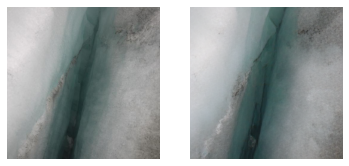

In [10]:
# normal VAE pass
batch = dataset[16]
with torch.no_grad():
    x = torch.from_numpy(batch['image'][None]).to(device)
    x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format)
    c = x
    quant_z, z_indices = model.encode_to_z(x)
    rec = model.decode_to_img(z_indices, quant_z.shape)
imshow([to_img(x), to_img(rec)])

In [1]:
# maskgit pass (high mask ratio test)
model.sampling_ratio = 0.1
model.mask_scheduler = "cosine" # cosine, linear
bidx = 16
batch = dataset[bidx]

app_root = f"logs/eval/app_b{bidx}"
os.makedirs(app_root,exist_ok=True)

def random_mask(z_indices, pkeep=0.5):
    L = z_indices.shape[-1]
    r_indices = torch.full_like(z_indices, model.mask_token)
    for i in range(L):
        r_indices[0,0] = z_indices[0,0]
        if np.random.rand() < pkeep:
            r_indices[0,i] = z_indices[0,i]
    return r_indices

def box_mask(z_indices, pkeep=0.5):
    r_indices = torch.full_like(z_indices, model.mask_token)
    m = model.box_mask(z_indices,p=(1-pkeep), det=True)
    return m*z_indices+(1-m)*r_indices

def reverse_box_mask(z_indices, pkeep=0.5):
    r_indices = torch.full_like(z_indices, model.mask_token)
    m = model.box_mask(z_indices,p=pkeep, det=True)
    return (1-m)*z_indices+m*r_indices

pkeep = 0.2

with torch.no_grad():
    model.eval()
    x = torch.from_numpy(batch['image'][None]).to(device)
    x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format)
    # imsave(os.path.join(app_root,"source.png"), to_img(x))
    c = x
    quant_z, z_indices = model.encode_to_z(x)
    quant_c, c_indices = model.encode_to_c(c)
    L = z_indices.shape[-1]
    for k in range(1):
        print(f"Generating sample {k:02d}...")

        # RANDOM MASK
        # r_indices = random_mask(z_indices, pkeep)                

        # BOX MASK
        r_indices = box_mask(z_indices,pkeep=pkeep)
        
        # sampling
        index_sample = model.sample(r_indices, c_indices,
                                    temperature=1,
                                    temperature_degradation=0.5,
                                    sample=True,
                                    callback=lambda k: None)
        gen = model.decode_to_img(index_sample, quant_z.shape)
        # imsave(os.path.join(app_root,f"gen_{k}.png"), to_img(gen))

mask = (r_indices != -1).float().reshape(1,1,16,16)
mask = torch.nn.functional.interpolate(mask, (256,256))
imshow([to_img(mask*x), to_img(gen)])

NameError: name 'model' is not defined

In [12]:
r_indices

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0',
       dtype=torch.int32)

In [ ]:
# maskgit pass (high mask ratio test)
pkeep = 0.05
model.sampling_ratio = 0.2
model.mask_scheduler = "cosine" # cosine, linear
batch = dataset[9]

with torch.no_grad():
    model.eval()
    x = torch.from_numpy(batch['image'][None]).to(device)
    x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format)
    c = x
    quant_z, z_indices = model.encode_to_z(x)
    quant_c, c_indices = model.encode_to_c(c)
    L = z_indices.shape[-1]
    r_indices = torch.full_like(z_indices, model.mask_token)
    for i in range(L):
        r_indices[0,0] = z_indices[0,0]
        if np.random.rand() < pkeep:
            r_indices[0,i] = z_indices[0,i]

    # sampling
    index_sample = model.sample(r_indices, c_indices,
                                temperature=1,
                                temperature_degradation=0.6,
                                sample=True,
                                callback=lambda k: None)
    gen = model.decode_to_img(index_sample, quant_z.shape)
    
imshow([to_img(gen)])